## The sixth Lab-assignment (08/02/2022 11:59'AM' - 08/05/2022 11:59PM, 50 points in total)

The purpose of this exercise is to build a simple predicition model which can helpyou understand the workflow of machine learning. 

### Q1 Task Decription (50 Points)

The goal of this assignment is to predict bike share use, given the hour, day, and information about the weather. Companies like Divvy try to predict how much demand there will be for bikes on any given day to allocate resources to redistribute bikes so that, ideally, very few bike stations are ever full (when you can’t park your bike) or empty (when you can’t pick up a bike if you want to).

The data (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06) in Github provides detailed information on the data set and necessary downloads.

### Data Description

You are provided hourly rental data spanning two years (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06). For this task, the training set is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or its components "casual" and "registered".

Data Fields

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1 - Clear, Few clouds, Partly cloudy, Partly cloudy

2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Output

Submission Format

Your output (a separate file) must have a header line and should be structured in the following format:

 datetime,count
 
 2011-01-20 00:00:00,0 
 
 2011-01-20 01:00:00,0
 
 2011-01-20 02:00:00,0
 
 ...
 
The tutorial code should demonstrate how to generate such a file from a very simple prediction model. Note, these prediction are to be done on the test file under the data tab, where you do not know the actual count, and should match the rows of the test file in count and order.

Your predictions should be compared to the ground truth information (sample_prediction.csv). Score are calculated using Root Mean Squared Error (RMSE).

### Tips

●	Add features: Pick columns/features from the data you already have. Or make a new feature from the ones you have. For example, the tutorial makes ‘hour’ from the datetime stamp, which seemed very useful. How about ‘month’?

●	Model selection: Try different models. Make sure they are regression models rather than classification models. Tip: random forest regression is a good, all around modeling strategy on complicated data sets.

●	Model tuning: Almost all regression models have parameters to tune (“hyperparameters”). E.g. polynomial regression has the degree of the polynomial (n = 1 for a line, n=2 for a quadratic fit, n=3 for a cubic fit…). Generally, one extreme makes the model too simple (e.g. a line for a curved set of points) and the other extreme makes the model overfit/be too complex, and usually the right choice is in between. For some models it is obvious what to tune (e.g. k for k nearest neighbors regression) and some don’t need much tuning with defaults that often work well. e.g. try changing the number of trees used in the random forest model!

●	Cross validation: The tutorial has a simple way of separating training and test data, however, there are better ways of splitting training and test data. Look into cross validation techniques, which are more reliable than an arbitrary split of training and test data.

●	Separate models for ...: Notice that count comes from just adding casual riders and registered riders. However, what if these two types of riders acted very differently? It might make sense to make two separate models and just add the results of both models together. This is also true for any subsets of your data that may behave wildly differently (e.g. create a separate model for each season?)

### Your code

In [221]:
### You code here:
#importing required libraries
import pandas as pd
import numpy as np
import csv as csv
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [222]:
# reading the data into train dataframe
train_df = pd.read_csv('train_luc.csv', header=0)

print("\nNumber of samples:",train_df.shape[0],"and number of features:",train_df.shape[1],"\n")

train_df.head()


Number of samples: 9174 and number of features: 12 



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [223]:
train_df.describe()  #describing the numerical attributes of the data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
mean,2.505559,0.031284,0.678875,1.414868,20.130401,23.578433,61.715064,12.737931,35.713647,154.868106,190.581753
std,1.116618,0.174094,0.466934,0.635363,7.940504,8.617957,19.401829,8.199027,49.667738,150.981155,181.011530
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,35.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,61.000000,11.001400,16.000000,117.000000,144.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,48.000000,222.000000,282.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000


In [224]:
# creating a new feature using the datetime feature
def hour_of_day(dt):
    return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").time().hour   #getting hour from datetime
train_df['hour'] = train_df['datetime'].map(hour_of_day)
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Text(0.5, 1.0, 'Measured bike use over 2 years')

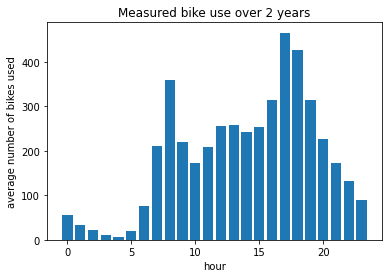

In [225]:
# visualizing average number of bikes used per every hour of the day
hours = np.unique(train_df['hour'])
print("hours:",hours)

hours_mean = {}
for h in hours:
    temp_df = train_df.loc[train_df['hour'] == h]
    hours_mean[h] = temp_df['count'].mean()

# plot the results. Maybe should see peaks from bike commuting or evening use
plt.bar(hours,[hours_mean[h] for h in hours])
plt.xlabel("hour")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

In [226]:
#feature selection for x and y
x=train_df[['hour','season','holiday','workingday','weather']]   
y=train_df[['count']]
cols=['hour','season','holiday','workingday','weather']


#splitting the data using train_test_split method to train and test the model beforehand
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.25, random_state=25)

In [227]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

# pick one by commenting/uncommenting
#model = DecisionTreeRegressor()
#model = LinearRegression()
#model = KNeighborsRegressor(n_neighbors = 5)
#model = svm.LinearSVR()
for i in [1,5,20,50,100]:   # hyperparameter tuning using n_estimators
  model = RandomForestRegressor(n_estimators = i)

  print("columns selected for later:",cols)
  print(model)


  # fit the model to the training subset of original training data
  model.fit(x_train, y_train)

  # predict on the testing subset of the original training data
  pred_count = model.predict(x_test)

  # score the model on the new test set
  rms = np.sqrt(mean_squared_error(y_test,pred_count))
  print("RMS error:",rms)

columns selected for later: ['hour', 'season', 'holiday', 'workingday', 'weather']
RandomForestRegressor(n_estimators=1)
RMS error: 92.33773237723217
columns selected for later: ['hour', 'season', 'holiday', 'workingday', 'weather']
RandomForestRegressor(n_estimators=5)
RMS error: 87.36788389302625
columns selected for later: ['hour', 'season', 'holiday', 'workingday', 'weather']
RandomForestRegressor(n_estimators=20)
RMS error: 86.33190033340131
columns selected for later: ['hour', 'season', 'holiday', 'workingday', 'weather']
RandomForestRegressor(n_estimators=50)
RMS error: 85.74614219919881
columns selected for later: ['hour', 'season', 'holiday', 'workingday', 'weather']
RandomForestRegressor()
RMS error: 86.247516134696


RandomForestReggressor seems to work best with 20 as its n_estimator parameter, so i am choosing 20 as my n_estimators value.

In [228]:
model=RandomForestRegressor(n_estimators=20)

# reading in the test data
test_df = pd.read_csv('test_luc.csv')
print("\nNumber of samples:",test_df.shape[0],"and number of features:",test_df.shape[1],"\n")

test_df['hour'] = test_df['datetime'].map(hour_of_day)  #mapping the hour to particular records

test_df.head()


Number of samples: 1712 and number of features: 9 



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour
0,2011-01-17 00:00:00,1,1,0,2,8.20,9.850,47,15.0013,0
1,2011-01-17 01:00:00,1,1,0,2,8.20,9.850,44,12.9980,1
2,2011-01-17 02:00:00,1,1,0,2,7.38,8.335,43,16.9979,2
3,2011-01-17 03:00:00,1,1,0,2,7.38,9.090,43,12.9980,3
4,2011-01-17 04:00:00,1,1,0,2,7.38,9.850,43,8.9981,4


In [229]:
# fitting the selected model with my whole dataframes
model.fit(x, y)

#predicting values from test_df
pred_count = model.predict(test_df[cols])

# adding the predicted value column
test_df['count'] = pred_count

test_df['count']=test_df['count'].round() #rounding the values

#printing the output
print("datetime,count")
for i in range(1712):
  print(test_df['datetime'][i],int(test_df['count'][i]),sep=',')

# saving the predicted count as a csv with a header column and datetime row
test_df = test_df[['datetime','count']].to_csv('my_prediction.csv', 
    index=False, header=True)
print("Prediction is complete and saved as my_prediction.csv")

datetime,count
2011-01-17 00:00:00,31
2011-01-17 01:00:00,20
2011-01-17 02:00:00,15
2011-01-17 03:00:00,8
2011-01-17 04:00:00,5
2011-01-17 05:00:00,4
2011-01-17 06:00:00,13
2011-01-17 07:00:00,23
2011-01-17 08:00:00,45
2011-01-17 09:00:00,52
2011-01-17 10:00:00,117
2011-01-17 11:00:00,145
2011-01-17 12:00:00,195
2011-01-17 13:00:00,194
2011-01-17 14:00:00,209
2011-01-17 15:00:00,185
2011-01-17 16:00:00,174
2011-01-17 17:00:00,173
2011-01-17 18:00:00,103
2011-01-17 19:00:00,61
2011-01-17 20:00:00,45
2011-01-17 21:00:00,52
2011-01-17 22:00:00,40
2011-01-17 23:00:00,24
2011-01-18 12:00:00,127
2011-01-18 13:00:00,132
2011-01-18 14:00:00,113
2011-01-18 15:00:00,89
2011-01-18 16:00:00,136
2011-01-18 17:00:00,256
2011-01-18 18:00:00,310
2011-01-18 19:00:00,231
2011-01-18 20:00:00,159
2011-01-18 21:00:00,96
2011-01-18 22:00:00,74
2011-01-18 23:00:00,47
2011-01-19 00:00:00,19
2011-01-19 01:00:00,7
2011-01-19 02:00:00,3
2011-01-19 04:00:00,2
2011-01-19 05:00:00,14
2011-01-19 06:00:00,61
2011-01-

 Question 2 (20 points) Build a regession model to predict the change in price of the stock overtime. It can either be linear regression or non-linear regression. You can download the dataset from here: https://github.com/suthapalliuday/INFO5502-Summer2022/blob/main/datasets/portfolio_data.csv. The implementation of the LSTM on this same dataset was posted here as an reference: https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook

 ### Your code

In [230]:
### You code here:
df=pd.read_csv("portfolio_data.csv")
df.head()

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


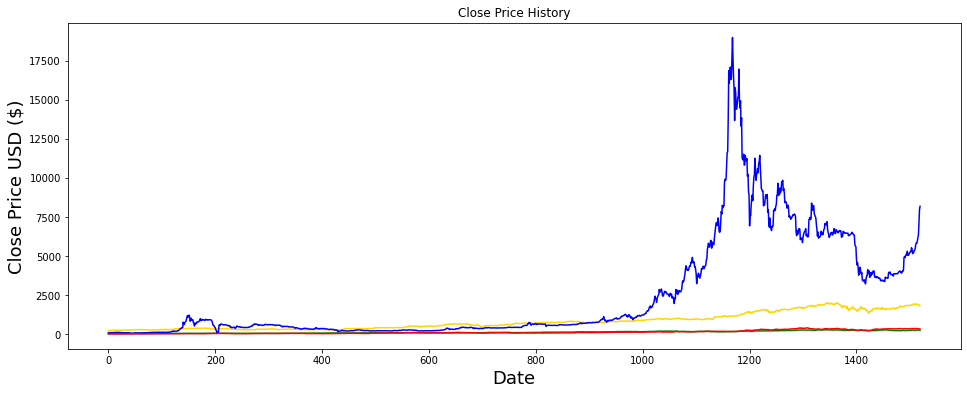

In [231]:
#plotting the closing prices of 4 stocks
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['AMZN'], color='gold')
plt.plot(df['DPZ'], color='green')
plt.plot(df['BTC'], color='blue')
plt.plot(df['NFLX'], color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [232]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [233]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['AMZN','DPZ','BTC','NFLX']])

scaled_data

array([[0.        , 0.        , 0.00193571, 0.00244266],
       [0.00241169, 0.00321824, 0.00150455, 0.00302215],
       [0.00548211, 0.00507347, 0.00228751, 0.00264071],
       ...,
       [0.91652336, 0.91809901, 0.37675649, 0.85127306],
       [0.87895251, 0.8999536 , 0.41848448, 0.81076018],
       [0.88868853, 0.89583139, 0.42926075, 0.81165869]])

In [234]:
import datetime as dt
df['Date'] = pd.to_datetime(df['Date'])
df['Date']=df['Date'].map(dt.datetime.toordinal)

forecast=[737194,737195,737196,737199,737200,737201,737202,737203,737206,737207,737208,737209,737210,737213,737214,737215,737216,737217]
forecast=np.array(forecast).reshape(-1,1)

In [235]:
amzn_model=LinearRegression()   #model for amazon
dpz_model=LinearRegression()    #model for dpz
btc_model=LinearRegression()    #model for btc
nflx_model=LinearRegression()   #model for nflx
amzn_model.fit(df[['Date']], df.AMZN)   #fitting the amazon data
dpz_model.fit(df[['Date']], df.DPZ)   #fitting the dpz data
btc_model.fit(df[['Date']], df.BTC)   #fitting the btc data
nflx_model.fit(df[['Date']], df.NFLX)   #fitting the nflx data
preds_amzn=[]
preds_dpz=[]
preds_btc=[]
preds_nflx=[]

#predicting future values
for i in forecast:
  preds_amzn.append(amzn_model.predict([i]))
  preds_dpz.append(dpz_model.predict([i]))
  preds_btc.append(btc_model.predict([i]))
  preds_nflx.append(nflx_model.predict([i]))

forecast=[int(i) for i in forecast]
preds_amzn=[float(i) for i in preds_amzn] 
preds_dpz=[float(i) for i in preds_dpz]
preds_btc=[float(i) for i in preds_btc]
preds_nflx=[float(i) for i in preds_nflx]


#creating a dataframe with predicted values
pred_df = pd.DataFrame(
    {'Date': forecast,
     'AMZN':preds_amzn,
     'DPZ':preds_dpz,
     'BTC':preds_btc,
     'NFLX':preds_nflx
    })

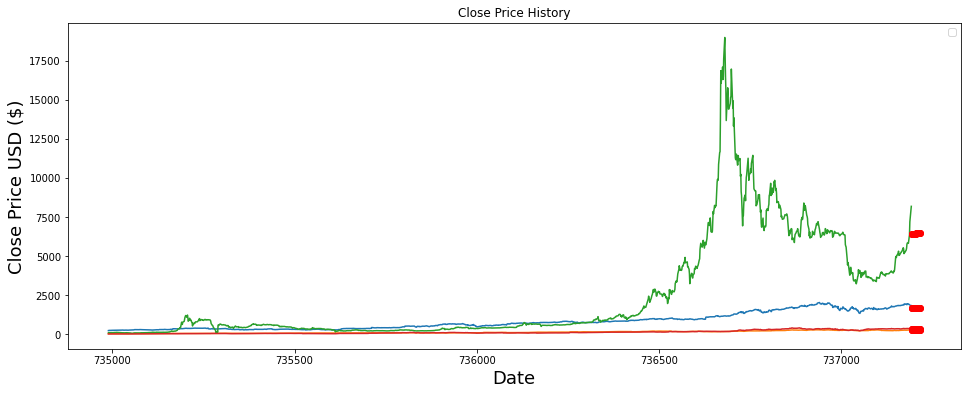

In [236]:
#plotting existing data along with the predicted data
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Date'],df['AMZN'])
plt.plot(df['Date'],df['DPZ'])
plt.plot(df['Date'],df['BTC'])
plt.plot(df['Date'],df['NFLX'])
plt.plot(pred_df['Date'],pred_df['AMZN'], color='red',marker='o', linestyle='dashed')
plt.plot(pred_df['Date'],pred_df['DPZ'], color='red',marker='o', linestyle='dashed')
plt.plot(pred_df['Date'],pred_df['BTC'], color='red',marker='o', linestyle='dashed')
plt.plot(pred_df['Date'],pred_df['NFLX'], color='red',marker='o', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

In [237]:
#changing date back to datetime format
pred_df['Date']=pred_df['Date'].map(dt.date.fromordinal)
pred_df  #future forecast (these dates are not included in the original dataset)

,Date,AMZN,DPZ,BTC,NFLX
0,2019-05-15,1660.807404,267.601626,6403.128568,315.984159
1,2019-05-16,1661.567448,267.711051,6406.734384,316.136587
2,2019-05-17,1662.327491,267.820475,6410.340200,316.289014
3,2019-05-20,1664.607622,268.148748,6421.157648,316.746298
4,2019-05-21,1665.367666,268.258172,6424.763464,316.898725
5,2019-05-22,1666.127709,268.367596,6428.369279,317.051153
6,2019-05-23,1666.887753,268.477020,6431.975095,317.203581
7,2019-05-24,1667.647796,268.586445,6435.580911,317.356009
8,2019-05-27,1669.927927,268.914717,6446.398359,317.813292
9,2019-05-28,1670.687970,269.024142,6450.004175,317.965720
